In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

from tqdm.notebook import tqdm

import gymnasium as gym
from minigrid.wrappers import RGBImgPartialObsWrapper, ImgObsWrapper, FullyObsWrapper

In [9]:
device = 'cuda:3'

  0%|          | 0/1000 [00:00<?, ?it/s]

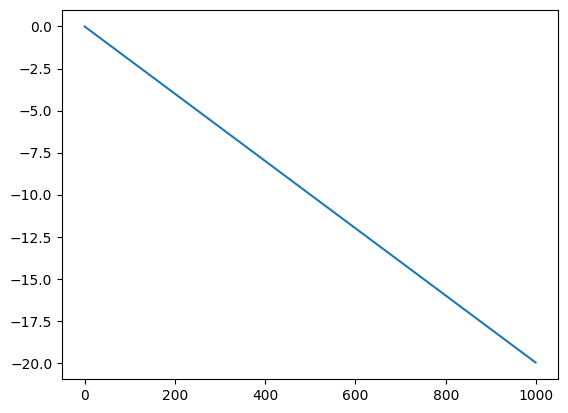

In [10]:
logits = torch.zeros(2).requires_grad_()

opt = torch.optim.Adam([logits], lr=1e-2)
losses = []
pbar = tqdm(range(1000))
for _ in pbar:
    log_sm = -torch.log_softmax(logits, dim=-1)
    
    # loss = log_sm[0]#-log_sm[1]
    loss = log_sm[0]-log_sm[1]
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    losses.append(loss.item())
    pbar.set_postfix(loss=loss.item())
plt.plot(losses)

In [11]:
class MyLavaGrid():
    def __init__(self, size_grid=100, obs_size=9, p_lava=0.15, n_envs=10, dead_screen=True):
        super().__init__()
        assert obs_size % 2==1
        self.size_grid = size_grid
        self.map = torch.rand(self.size_grid, self.size_grid) < p_lava
        self.k = k = obs_size//2
        self.map[k:k+3, k:k+3] = False
        self.map[:k] = True; self.map[:, :k] = True
        self.map[-k:] = True; self.map[:, -k:] = True
        self.n_envs = n_envs
        self.dead_screen = dead_screen

        self.action2vec = torch.tensor([[ 1,  0],
                                        [ 0,  1],
                                        [-1,  0],
                                        [ 0, -1]])
        self.reset()
        
        self.observation_space = type('', (), {})()
        self.observation_space.sample = lambda : torch.rand((self.n_envs, 2*k+1, 2*k+1), device=self.map.device)
        self.observation_space.shape = (2*k+1, 2*k+1)
        self.action_space = type('', (), {})()
        self.action_space.sample = lambda : torch.randint(0, len(self.action2vec), size=(self.n_envs, ), dtype=torch.long, device=self.map.device)
        self.action_space.n = len(self.action2vec)
        
    def to(self, *args, **kwargs):
        self.map = self.map.to(*args, **kwargs)
        self.action2vec = self.action2vec.to(*args, **kwargs)
        return self
        
    def reset(self, snapshot=None):
        if snapshot is None:
            self.snapshot = torch.full((self.n_envs, 2), self.k, dtype=torch.long, device=self.map.device)
        else:
            self.snapshot = snapshot.to(self.map.device)
        obs, done = self.calc_obs_done()
        reward = torch.zeros(self.n_envs, device=self.map.device)
        info = None # [{} for _ in range(self.n_envs)]
        return self.snapshot, obs, reward, done, info
    
    def step(self, action):
        action = self.action2vec[action]
        done = self.map[self.snapshot[:, 0], self.snapshot[:, 1]]
        self.snapshot = torch.where(done[:, None], self.snapshot, self.snapshot + action)
        self.snapshot = torch.clamp(self.snapshot, min=self.k, max=self.size_grid-self.k-1)
        
        obs, done = self.calc_obs_done()
        reward = torch.zeros(self.n_envs, device=self.map.device)
        done = self.map[self.snapshot[:, 0], self.snapshot[:, 1]]
        info = None # [{} for _ in range(self.n_envs)]
        return self.snapshot, obs, reward, done, info
    
    def calc_obs_done(self, snapshot=None):
        snapshot = self.snapshot if snapshot is None else snapshot
        obs = torch.stack([self.map[x-self.k: x+self.k+1, y-self.k: y+self.k+1] for (x, y) in snapshot]).float()
        done = self.map[snapshot[:, 0], snapshot[:, 1]]
        if self.dead_screen:
            obs[done] = 1.
        return obs, done
    
    def to_latent(self, snapshot, obs):
        done = self.map[snapshot[:, 0], snapshot[:, 1]]
        return [(tuple(a.tolist()) if not d else (-1, -1)) for a, d in zip(snapshot, done)]

In [12]:
env = MyLavaGrid(obs_size=11, dead_screen=False)
snapshot, obs, reward, done, info = env.reset()

In [13]:
snapshot, obs, reward, done, info = env.reset()
for i in range(100):
    snapshot, obs, reward, done, info = env.step(env.action_space.sample())

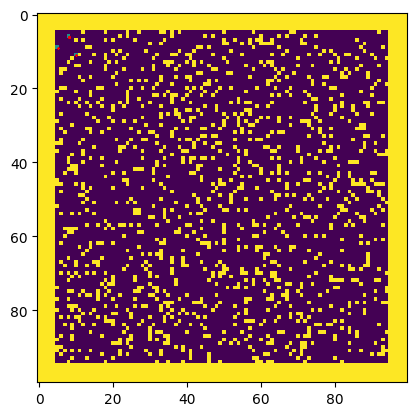

In [14]:
def render_snapshots(env, snapshot):
    img = env.map.clone().cpu().float()
    img[snapshot[:, 0], snapshot[:, 1]] = 0.5
    plt.scatter(snapshot[:, 1], snapshot[:, 0], marker='x', s=1., color='r')
    plt.imshow(img.numpy())

render_snapshots(env, snapshot)

In [27]:
def tensor_stack(a):
    if isinstance(a, torch.Tensor):
        return a
    elif isinstance(a, list):
        return torch.stack([tensor_stack(i) for i in a])
    
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer
    
class ImitationExplorer(nn.Module):
    def __init__(self, env, force_random=False):
        super().__init__()
        self.n_inputs = np.prod(env.observation_space.shape)
        self.n_outputs = env.action_space.n
        self.encoder = nn.Sequential(
            nn.Flatten(-2, -1),
            layer_init(nn.Linear(self.n_inputs, 20)),
            nn.Tanh(),
            layer_init(nn.Linear(20, 20)),
            nn.Tanh(),
            layer_init(nn.Linear(20, 20)),
        )
        self.critic = nn.Sequential(
            layer_init(nn.Linear(20, 20)),
            nn.Tanh(),
            layer_init(nn.Linear(20, 1)),
        )
        self.actor = nn.Sequential(
            layer_init(nn.Linear(20, 20)),
            nn.Tanh(),
            layer_init(nn.Linear(20, self.n_outputs)),
        )
        self.force_random = force_random
        self.opt = torch.optim.Adam(self.parameters(), lr=1e-4)
        
    def get_logits_values(self, x):
        x = self.encoder(x)
        logits, values = self.actor(x), self.critic(x)
        return logits, values

#     def get_action_and_value(self, x, action=None, ret_logits=False):
#         x = self.encoder(x)
#         logits, values = self.actor(x), self.critic(x)
#         print(logits.shape)
#         if self.force_random:
#             logits, values = torch.zeros_like(logits), torch.zeros_like(values)
        
#         dist = torch.distributions.Categorical(logits=logits)
#         if action is None:
#             action = dist.sample()
            
#         return action, dist.log_prob(action), dist.entropy(), values, dist
    
    def update_policy(self, ge, n_steps, batch_size, viz=False):
        obs_good = tensor_stack([[trans[1] for trans in traj] for traj in ge.trajs_good])
        actions_good = tensor_stack([[trans[3] for trans in traj] for traj in ge.trajs_good])
        obs_good = obs_good.reshape(-1, obs_good.shape[-1])
        actions_good = actions_good.reshape(-1)

        obs_bad = tensor_stack([[trans[1] for trans in traj] for traj in ge.trajs_bad])
        actions_bad = tensor_stack([[trans[3] for trans in traj] for traj in ge.trajs_bad])
        obs_bad = obs_bad.reshape(-1, obs_bad.shape[-1])
        actions_bad = actions_bad.reshape(-1)
        # print(obs_bad.shape)
        # print(obs_good.shape)


        losses = []
        for i_batch in range(n_steps):
            idx_good = torch.randperm(len(obs_good))[:batch_size//2]
            idx_bad = torch.randperm(len(obs_bad))[:batch_size//2]
            batch_obs_good = obs_good[idx_good].to(device)
            batch_obs_bad = obs_bad[idx_bad].to(device)
            batch_actions_good = actions_good[idx_good].to(device)
            batch_actions_bad = actions_bad[idx_bad].to(device)

            _, log_probs_good, entropy, logits_good = self.get_action_and_value(batch_obs_good, batch_actions_good, ret_logits=True)
            _, log_probs_bad, entropy, logits_bad = self.get_action_and_value(batch_obs_bad, batch_actions_bad, ret_logits=True)

            # loss = log_probs_bad.mean()-log_probs_good.mean()

            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
            losses.append(loss.item())


        batch_actions = torch.cat([batch_actions_good, batch_actions_bad], dim=0)
        log_probs = torch.cat([log_probs_good, log_probs_bad], dim=0)

        self.losses_all.extend(losses)
        if viz:
            plt.plot(losses)
            plt.show()
            for i in range(4):
                print(f'Action {i}')
                print(log_probs[batch_actions==i].mean().item())

# do_training(10, 2048)
class RandomExplorer(nn.Module):
    def __init__(self):
        super().__init__()
        
    def get_action_and_value(self, x, action=None):
        logits = torch.zeros(x.shape[:-1]+(4,))
        probs = torch.distributions.Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), 0.

In [28]:
explorer = ImitationExplorer(env, force_random=False)

In [33]:
o = env.observation_space.sample()
logits, _ = explorer.get_logits_values(o)

In [34]:
logits.shape

torch.Size([10, 4])

In [1071]:
class Node():
    def __init__(self, parent, traj, snapshot, obs, latent):
        self.parent = parent
        self.children = []
        
        self.traj = traj

        self.snapshot = snapshot
        self.obs = obs
        self.latent = latent
        
    def get_full_trajectory(self):
        return ([] if self.parent is None else self.parent.get_full_trajectory()) + self.traj

from collections import defaultdict
class GoExplore(list):
    def __init__(self, env, explorer, device=None):
        self.env = env
        self.explorer = explorer
        self.device = device

        self.cell2node = {}
        self.cell2n_seen = defaultdict(lambda : 0)
        snapshot, obs, reward, done, info = self.env.reset()
        node_root = Node(None, [], snapshot[0].cpu(), obs[0].cpu(), self.env.to_latent(snapshot, obs)[0])
        self.node_root = node_root
        # print(self.env.to_latent(snapshot, obs))
        self.add_node(node_root)
        
        # self.trajs_good = []
        # self.trajs_bad = []
        
    def add_node(self, node):
        self.cell2node[node.latent] = node
        self.append(node)
        if node.parent:
            node.parent.children.append(node)
        
    def add_node(self, node):
        self.cell2n_seen[node.latent] += 1
        self.append(node)
        if node.parent:
            node.parent.children.append(node)
            
        if node.latent in self.cell2node:
            node_old = self.cell2node[node.latent]
            if len(node.get_full_trajectory())<len(node_old.get_full_trajectory()):
                self.cell2node[node.latent] = node
        else:
            self.cell2node[node.latent] = node
    
    def select_nodes(self, n_nodes):
        cells = list(self.cell2node.keys())
        n_seen = np.array([self.cell2n_seen[cell] for cell in cells])
        p = 1./np.sqrt(n_seen+1)
        p = p/p.sum()
        return [self.cell2node[cells[i]] for i in np.random.choice(len(cells), size=n_nodes, p=p)]
    
    def explore_from_single(self, nodes, len_traj):
        trajs = [[] for _ in nodes] # list of tuples (snapshot, obs, action, reward)
        snapshot = torch.stack([node.snapshot for node in nodes]).to(device)
        snapshot, obs, reward, done, info = env.reset(snapshot)
        for i_trans in range(len_traj):
            with torch.no_grad():
                action, log_prob, entropy, values = self.explorer.get_action_and_value(obs)
                # action, log_prob = action.cpu(), log_prob.cpu()
            snapshot_next, obs_next, reward, done, info = self.env.step(action)
            for i, traj in enumerate(trajs):
                traj.append((snapshot[i].cpu(), obs[i].cpu(), action[i].cpu(), reward[i].cpu()))
            snapshot, obs = snapshot_next, obs_next
            
        latent = env.to_latent(snapshot, obs)
        return [Node(nodes[i], trajs[i], snapshot[i].cpu(), obs[i].cpu(), latent[i]) for i in range(len(nodes))]
    
    def explore_from(self, nodes, len_traj, n_trajs, add_nodes=True):
        for node in nodes:
            self.cell2n_seen[node.latent] += 1
            
        for _ in range(n_trajs):
            nodes = self.explore_from_single(nodes, len_traj)
            if add_nodes:
                for node in nodes:
                    self.add_node(node)

#     def step_explore(self, n_trajs, len_traj):
#         nodes = []
#         dones = []
#         for i_traj in range(n_trajs):
#             node_start = self.select_node()
#             self.env.reset(node_start.state_sim)
#             node_end, latents, done = self.explore_from(node_start, len_traj)
#             nodes.append(node_end)
#             dones.append(done)
            
#             for latent in latents:
#                 self.archive.cell2n_seen[latent] += 1
#             better = self.archive.add_if_better(node_end)
#             if better:
#                 self.trajs_good.append(node_end.traj)
#             else:
#                 self.trajs_bad.append(node_end.traj)
#         return nodes, latents, np.array(dones).mean()


In [1077]:
np.random.seed(0)
torch.manual_seed(0)
n_envs = 10
env = MyLavaGrid(obs_size=3, n_envs=n_envs, dead_screen=False).to(device)
snapshot, obs, reward, done, info = env.reset()
explorer = ImitationExplorer(env).to(device)
ge = GoExplore(env, explorer, device)
pbar = tqdm(range(10))
archive_size = []
for i in pbar:
    nodes = ge.select_nodes(n_envs)
    ge.explore_from(nodes, 1, 10)
    n_seen = torch.tensor(list(ge.cell2n_seen.values()))
    
    pbar.set_postfix(cells=len(ge.cell2node), n_seen_max=n_seen.max().item())
    archive_size.append(len(ge.cell2node))

  0%|          | 0/10 [00:00<?, ?it/s]

In [1083]:
# trajs = [node.get_full_trajectory() for node in ge if not node.children]

# for traj in trajs:
#     x = torch.stack([trans[0] for trans in traj]).float()
#     # print(x)
#     x = x+5e-2*torch.randn_like(x)
#     plt.plot(*x.numpy().T)
# plt.xlim(0, 8)
# plt.ylim(0, 15)

In [1108]:
n_envs = 10
env = MyLavaGrid(obs_size=3, n_envs=n_envs, dead_screen=False).to(device)
snapshot, obs, reward, done, info = env.reset()
explorer = ImitationExplorer(env).to(device)
ge = GoExplore(env, explorer, device)

In [1109]:
pbar = tqdm(range(500))
archive_size = []
for i in pbar:
    nodes = ge.select_nodes(n_envs)
    ge.explore_from(nodes, 1, 10)
    n_seen = torch.tensor(list(ge.cell2n_seen.values()))
    
    pbar.set_postfix(cells=len(ge.cell2node), n_seen_max=n_seen.max().item())
    archive_size.append(len(ge.cell2node))

  0%|          | 0/500 [00:00<?, ?it/s]

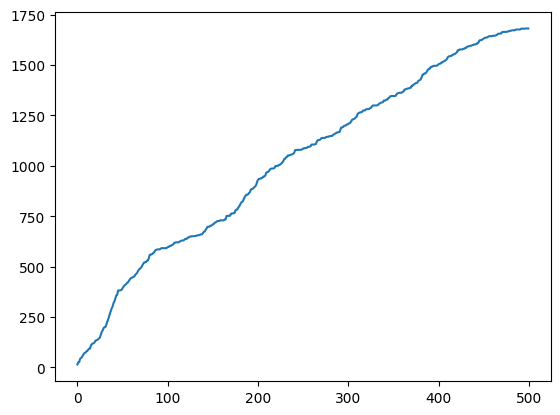

In [1110]:
plt.plot(archive_size)
plt.show()

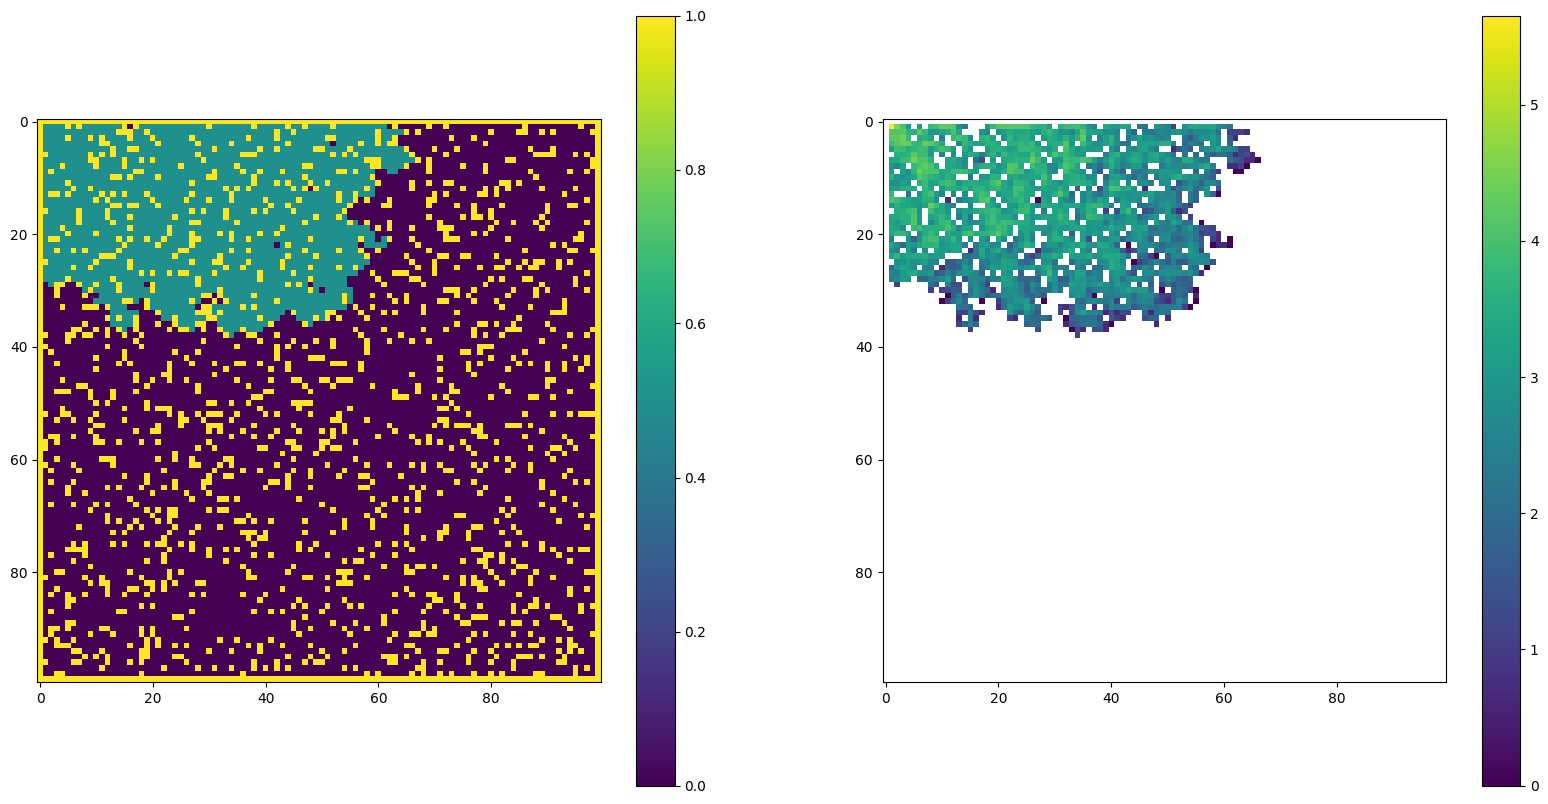

In [1151]:
def render_snapshots(ge):
    cells = [cell for cell in ge.cell2node.keys() if cell!=(-1, -1)]
    snapshot = torch.stack([ge.cell2node[cell].snapshot for cell in cells])
    n_seen = torch.tensor([ge.cell2n_seen[cell] for cell in cells])
    # n_seen = torch.tensor([node2prod[ge.cell2node[cell]] for cell in cells])
    
    # plt.plot(n_seen.sort(descending=True).values.numpy())
    # plt.yscale('log')
    # plt.show()
    
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    img = ge.env.map.clone().cpu().float()
    img[snapshot[:, 0], snapshot[:, 1]] = 0.5
    # plt.scatter(snapshot[:, 1], snapshot[:, 0], marker='x', s=1., color='r')
    plt.imshow(img.numpy())
    plt.colorbar()
    
    plt.subplot(122)
    img = torch.zeros_like(ge.env.map.clone().cpu().float())
    img[...] = float('nan')
    img[snapshot[:, 0], snapshot[:, 1]] = n_seen.float().log()
    plt.imshow(img.numpy())#, vmin=-40, vmax=0)
    plt.colorbar()
    

render_snapshots(ge)

In [1112]:
def calc_prods(ge, reduce1=np.max, reduce2=np.max):
    node2prod = {}
    def recurse(node):
        novelty = -ge.cell2n_seen[node.latent]
        if node.children:
            for child in node.children:
                recurse(child)
            prods_children = [node2prod[child] for child in node.children]
            
            if reduce2 is None:
                prod = reduce1([novelty]+prods_children)
            else:
                prod = reduce1([novelty, reduce2(prods_children)])
        else:
            prod = novelty
        node2prod[node] = prod
    recurse(ge.node_root)
    return node2prod


In [1128]:
node2n_seen = {node: ge.cell2n_seen[node.latent] for node in ge}
node2prod = calc_prods(ge)

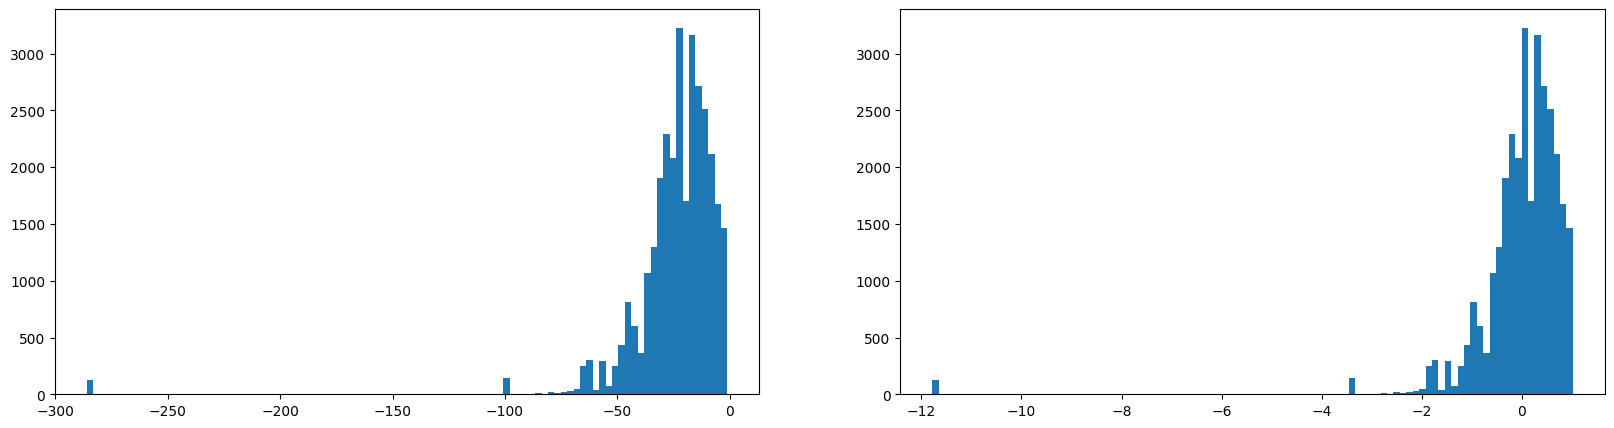

In [1129]:
plt.figure(figsize=(20, 5))
a = np.array([node2prod[node] for node in node2n_seen.keys() if node.latent!=(-1,-1)])
plt.subplot(121)
plt.hist(a, bins=100);
a = (a-a.mean())/(a.std()+1e-9)
plt.subplot(122)
plt.hist(a, bins=100);

In [1130]:
len(ge)

50001

torch.Size([31076, 3, 3]) torch.Size([31076]) torch.Size([31076])


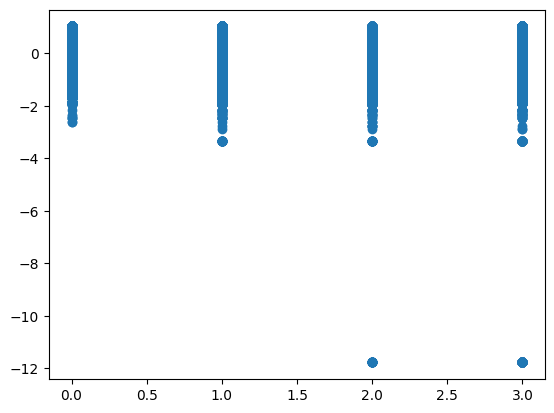

Average productivity of taking action 0: 0.10966203361749649
Average productivity of taking action 1: 0.12151945382356644
Average productivity of taking action 2: -0.017791656777262688
Average productivity of taking action 3: -0.1677067130804062


In [1131]:
def plot_dataset(ge):
    obs = torch.stack([trans[1] for node in ge for trans in node.traj if node.latent!=(-1,-1)])
    action = torch.stack([trans[2] for node in ge for trans in node.traj if node.latent!=(-1,-1)])
    prod = torch.tensor([node2prod[node] for node in ge for trans in node.traj if node.latent!=(-1,-1)]).float()
    # prod = torch.tensor([-ge.cell2n_seen[node.latent] for node in ge for trans in node.traj if node.latent!=(-1,-1)]).float()
    prod = (prod-prod.mean())/(prod.std()+1e-9)
    print(obs.shape, action.shape, prod.shape)
    
    plt.scatter(action.numpy(), prod.numpy())
    plt.show()
    for i in range(4):
        print(f'Average productivity of taking action {i}: {prod[action==i].mean().item()}')
    
    
plot_dataset(ge)

  0%|          | 0/1000 [00:00<?, ?it/s]

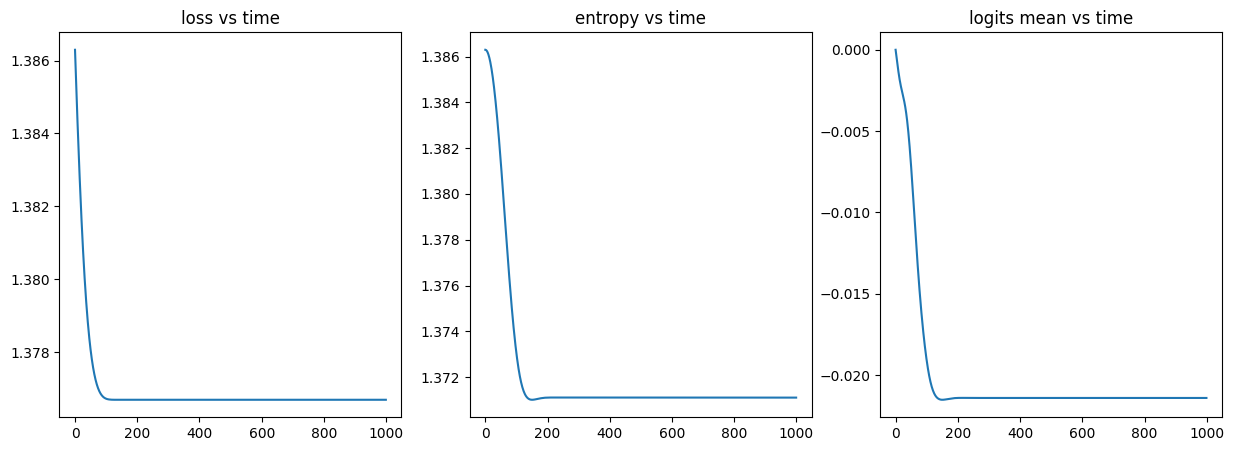

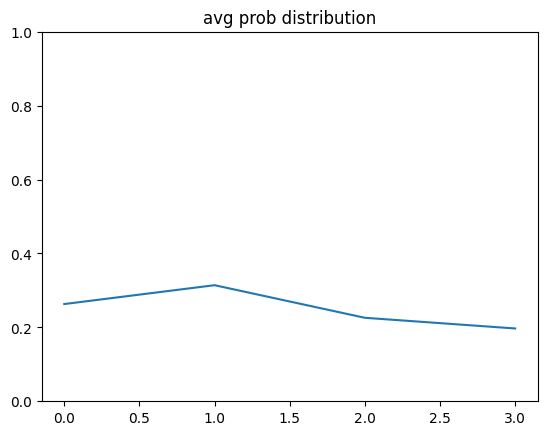

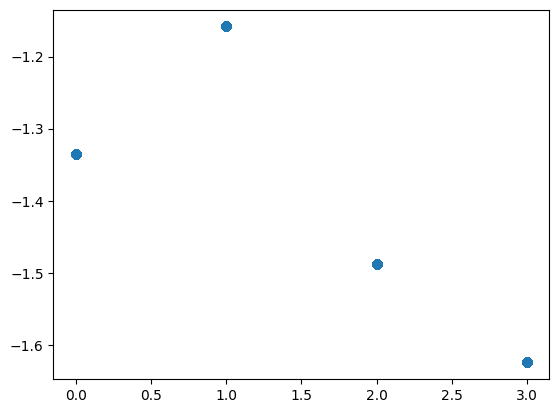

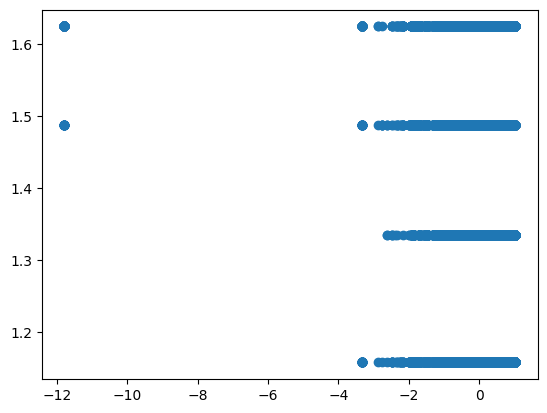

In [1150]:
def update_policy(ge, explorer, n_steps, batch_size=100, coef_entropy=1e-1, norm_batch=True, viz=False, device=None):
    obs = torch.stack([trans[1] for node in ge for trans in node.traj if node.latent!=(-1,-1)])
    action = torch.stack([trans[2] for node in ge for trans in node.traj if node.latent!=(-1,-1)])
    prod = torch.tensor([node2prod[node] for node in ge for trans in node.traj if node.latent!=(-1,-1)]).float()
    # prod = torch.tensor([-ge.cell2n_seen[node.latent] for node in ge for trans in node.traj if node.latent!=(-1,-1)]).float()
    prod = (prod-prod.mean())/(prod.std()+1e-9)
    # prod = prod.clamp(-2, 2)
    
    opt = torch.optim.Adam(explorer.parameters(), lr=1e-3)
    
    loss_fn = nn.CrossEntropyLoss(reduction='none')
    
    losses = []
    entropies = []
    logits_list = []
    pbar = tqdm(range(n_steps))
    for i_batch in pbar:
        idx = torch.randperm(len(obs))[:batch_size]
        b_obs, b_action, b_prod = obs[idx].to(device), action[idx].to(device), prod[idx].to(device)
        b_obs = torch.zeros_like(b_obs)
        if norm_batch:
            b_prod = (b_prod-b_prod.mean())/(b_prod.std()+1e-9)
        
        _, log_probs, entropy, values, logits = explorer.get_action_and_value(b_obs, b_action, ret_logits=True)
        
        loss1 = loss_fn(logits, b_action)
        # print(logits.shape, b_prod.shape)
        # loss2 = -log_probs
        # print(loss1.item()-loss2.item())
        
        # loss = (loss1*b_prod).mean()
        loss_data = loss_fn(logits*b_prod[:, None], b_action).mean()
        loss_entropy = -entropy.mean()
        # loss = (loss1).mean()
        
        loss = loss_data + coef_entropy*loss_entropy

        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
        entropies.append(entropy.mean().item())
        logits_list.append(logits.mean().item())
        
        pbar.set_postfix(loss=loss.item())

    if viz:
        plt.figure(figsize=(15, 5))
        plt.subplot(131); plt.plot(losses); plt.title('loss vs time')
        plt.subplot(132); plt.plot(entropies); plt.title('entropy vs time')
        plt.subplot(133); plt.plot(logits_list); plt.title('logits mean vs time')
        plt.show()
        
        plt.plot(logits.softmax(dim=-1).mean(dim=-2).detach().cpu().numpy())
        # plt.hist(logits.argmax(dim=-1).detach().cpu().numpy())
        plt.ylim(0,1)
        plt.title('avg prob distribution')
        plt.show()
        
        plt.scatter(b_action.detach().cpu().numpy(), log_probs.detach().cpu().numpy())
        plt.show()
        plt.scatter(b_prod.cpu().numpy(), loss1.detach().cpu().numpy())
        plt.show()
        
        # for i in range(4):
            # print(f'Action {i}')
            # print(log_probs[batch_actions==i].mean().item())
    
update_policy(ge, ImitationExplorer(env).to(device), 1000, batch_size=50000, coef_entropy=0., norm_batch=False, viz=True, device=device)
    

In [1152]:
len(ge)

50001

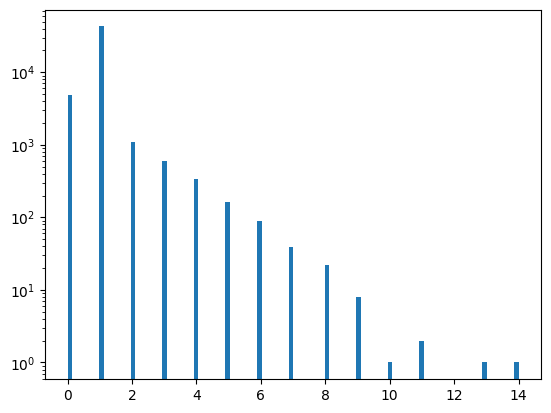

In [1158]:
plt.hist([len(node.children) for node in ge], bins=100);
plt.yscale('log')

In [942]:
loss_fn = nn.CrossEntropyLoss(reduction='none')

In [950]:
logits = torch.randn(10000, 10)+100
targets = torch.randint(0, 10, (10000, )).long()
loss = loss_fn(logits, targets)
print(loss.mean().item())

2.7239391803741455


  0%|          | 0/2000 [00:00<?, ?it/s]

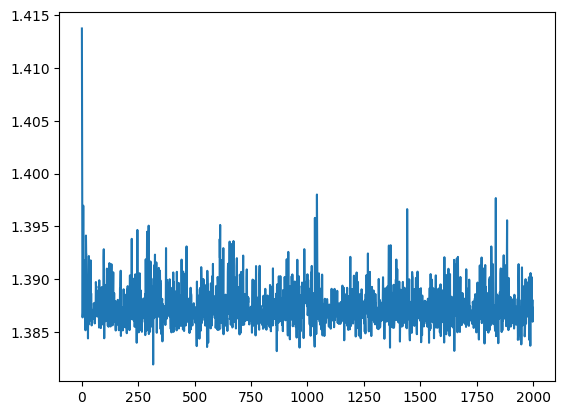

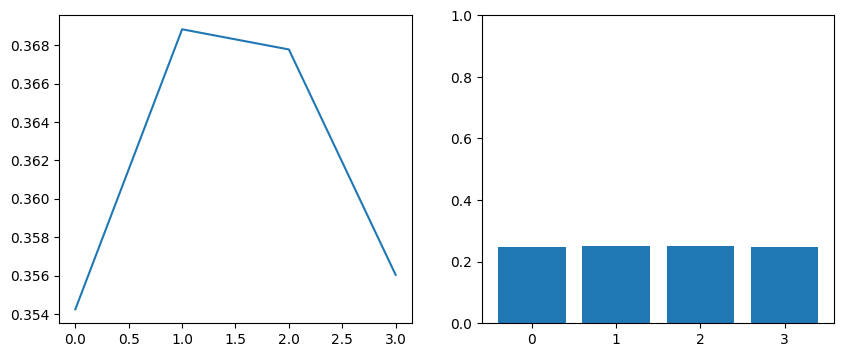

In [55]:
np.random.seed(1)
torch.manual_seed(1)

param = torch.randn(4).requires_grad_()

opt = torch.optim.Adam([param], lr=1e-1)

loss_fn = nn.CrossEntropyLoss(reduction='none')

losses = []
for _ in tqdm(range(2000)):
    logits = param.repeat(1000, 1)
    # action = torch.zeros(1000).long()
    action = torch.randint(0, 4, (1000,)).long()
    
    a = torch.randn(1000, 1)
    
    logits = logits*a
    
    logsm = torch.log_softmax(logits, dim=-1)
    log_prob = logsm[torch.arange(1000), action]
    
    loss1 = loss_fn(logits, action)
    loss2 = -log_prob
    
    loss = (loss1).mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    losses.append(loss.item())

plt.plot(losses)
plt.show()

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(param.tolist())
plt.subplot(122)
plt.bar(np.arange(4), param.softmax(dim=-1).tolist())
plt.ylim(0, 1)
plt.show()

$$\frac{e^{x_k}}{\sum_i e^{x_i}}$$

$$\frac{(e^{x_k})^{a_k}}{\sum_i (e^{x_i})^{a_i}}$$

$$\frac{(e^{x_k})^{a_k}}{\sum_i (e^{x_i})^{a_i}}$$

In [28]:
env = MyMiniGrid()
explorer = RandomExplorer().to(device)
# explorer = ImitationExplorer().to(device)
ge = GoExplore(env, explorer)
dones = []
archive_size = []
for i in tqdm(range(20)):
    _, _, done = ge.step_explore(100, 10)
    dones.append(done)
    archive_size.append(len(ge.archive))
    if isinstance(explorer, ImitationExplorer):
        explorer.update_policy(ge, n_steps=100, batch_size=10000)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Results for  RandomExplorer


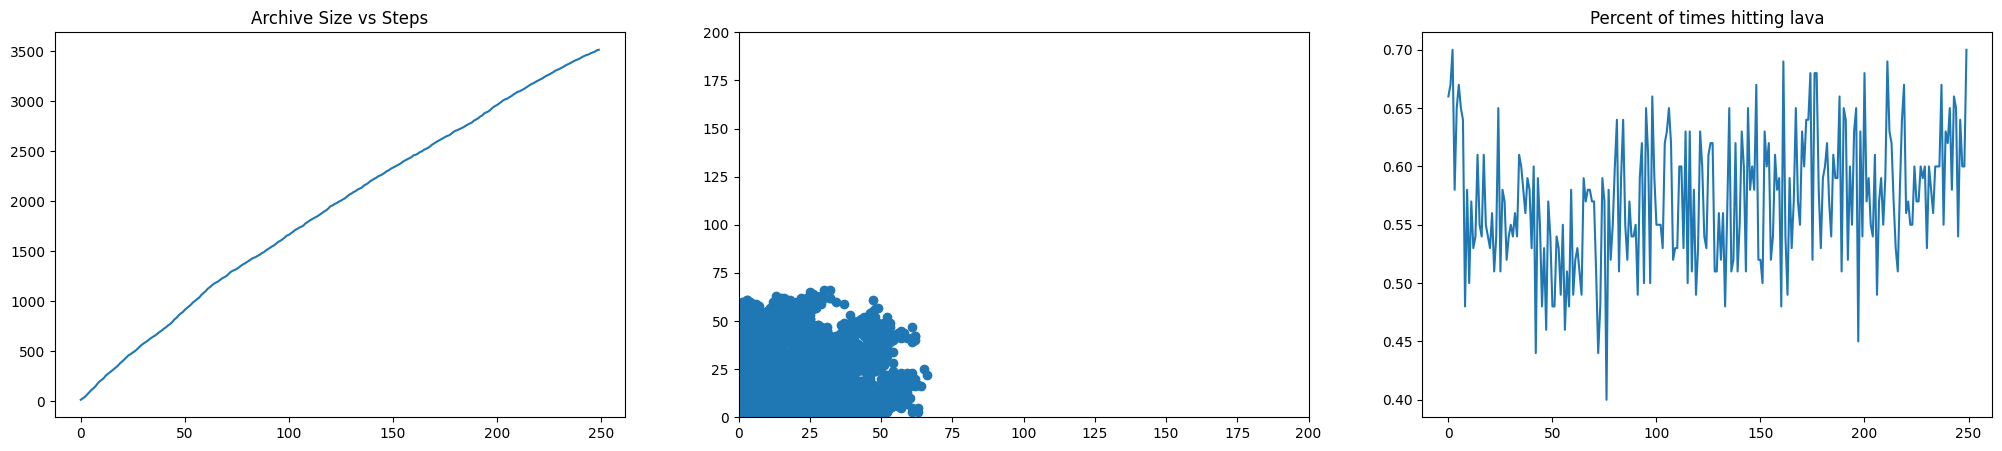

  0%|          | 0/250 [00:00<?, ?it/s]

Results for  ImitationExplorer


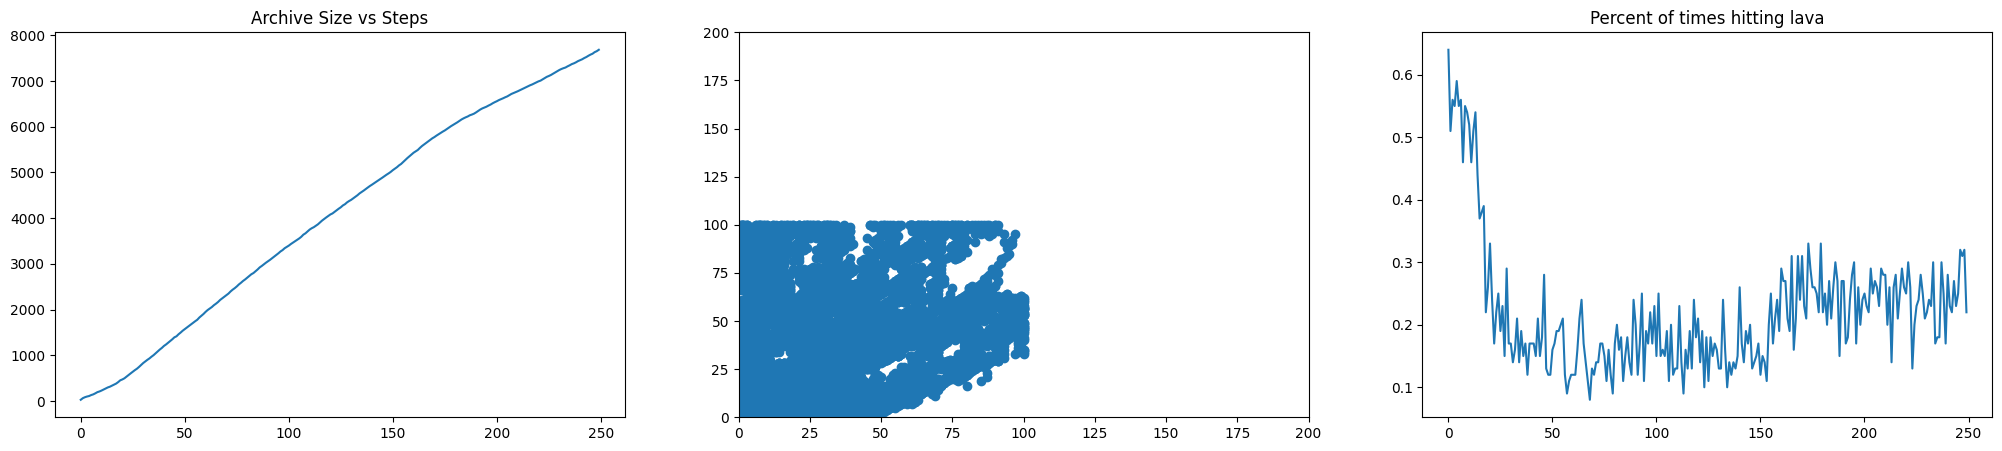

In [38]:
for Explorer in [RandomExplorer, ImitationExplorer]:
    env = MyMiniGrid()
    explorer = Explorer().to(device)
    ge = GoExplore(env, explorer)
    dones = []
    archive_size = []
    for i in tqdm(range(250)):
        _, _, done = ge.step_explore(100, 10)
        dones.append(done)
        archive_size.append(len(ge.archive))
        if isinstance(explorer, ImitationExplorer):
            explorer.update_policy(ge, n_steps=100, batch_size=10000)
    print('Results for ', explorer.__class__.__name__)
    x = np.array([node.latent for node in ge.archive])
    plt.figure(figsize=(25, 5))
    plt.subplot(131)
    plt.plot(archive_size)
    plt.title('Archive Size vs Steps')
    plt.subplot(132)
    plt.scatter(*x.T)
    plt.xlim(0, 200); plt.ylim(0, 200)
    plt.subplot(133)
    plt.plot(dones)
    plt.title('Percent of times hitting lava')
    plt.show()

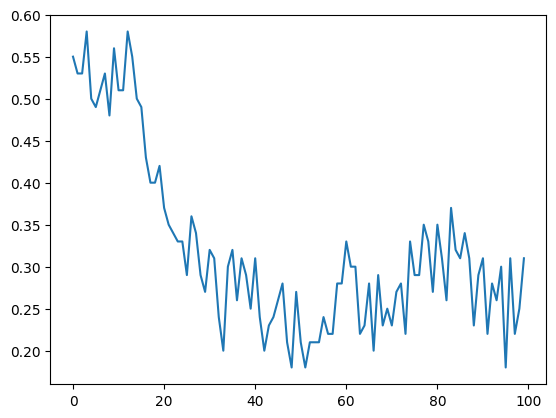

In [138]:
plt.plot(dones)

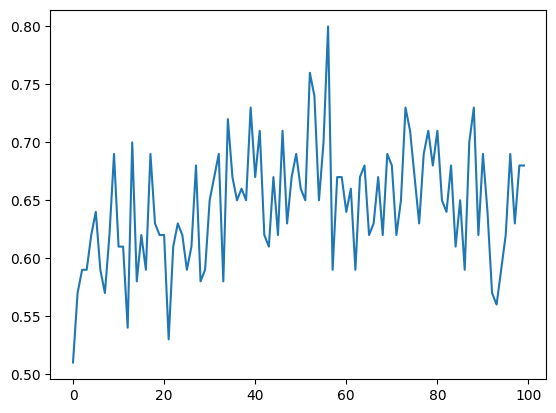

In [136]:
plt.plot(dones)

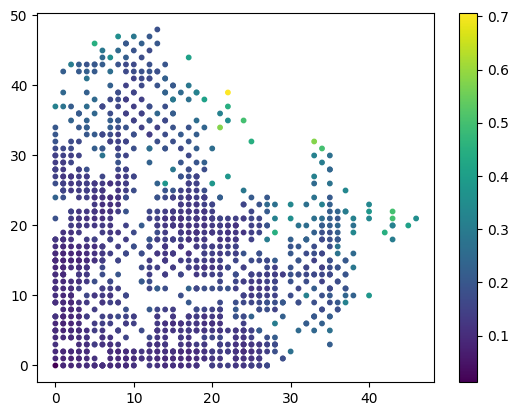

In [130]:
x = np.array([node.latent for node in ge.archive])
c = np.array([ge.archive.cell2n_seen[node.latent] for node in ge.archive])
c = 1./np.sqrt(c+1)
plt.scatter(*x.T, c=c, s=10.)
plt.colorbar()

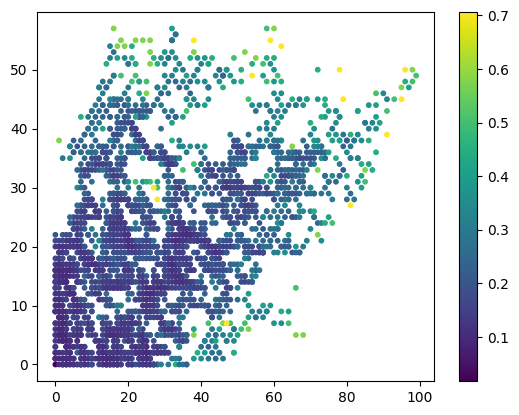

In [139]:
x = np.array([node.latent for node in ge.archive])
c = np.array([ge.archive.cell2n_seen[node.latent] for node in ge.archive])
c = 1./np.sqrt(c+1)
plt.scatter(*x.T, c=c, s=10.)
plt.colorbar()

In [165]:
x = np.array([node.latent for node in ge.archive])
c = np.array([ge.archive.cell2n_seen[node.latent] for node in ge.archive])
x.shape, c.shape

((2736, 2), (2736,))

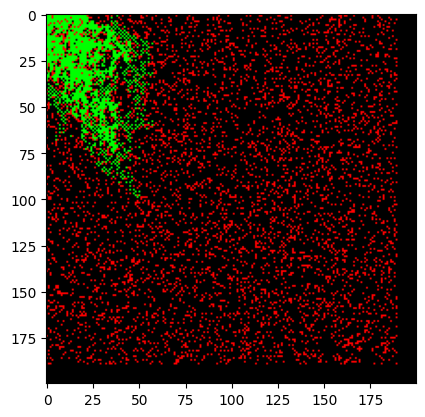

In [185]:
img = torch.zeros(200, 200, 3)
img[x[:, 0], x[:, 1], 1] += 1.
img[:190, :190, 0] += map_lava[10:, 10:]
plt.imshow(img)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

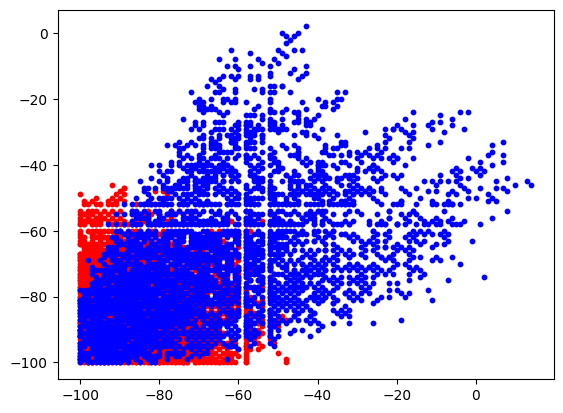

In [305]:
env = MyMiniGrid()
for Explorer in [RandomExplorer, ImitationExplorer]:
    explorer = Explorer().to(device)
    ge = GoExplore(env, explorer)
    for i in tqdm(range(50)):
        ge.step_explore(100, 10)
        if isinstance(explorer, ImitationExplorer):
            explorer.update_policy(ge, n_steps=100, batch_size=10000)
    x = np.array([node.latent for node in ge.archive])
    c = np.array([ge.archive.cell2n_seen[node.latent] for node in ge.archive])
    c = 1./np.sqrt(c+1)
    # plt.scatter(*x.T, c=c, s=10.)
    plt.scatter(*x.T, c='r' if isinstance(explorer, RandomExplorer) else 'b', s=10.)
    # plt.colorbar()
    # plt.show()

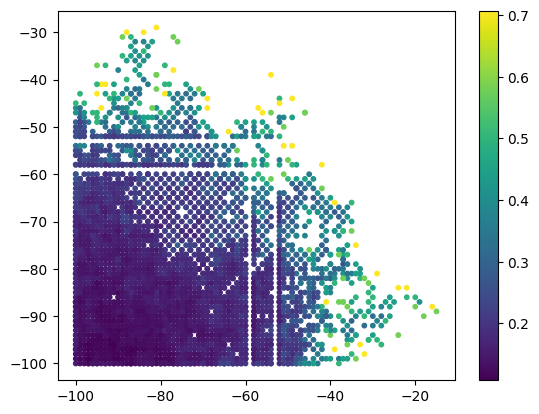

In [265]:
x = np.array([node.latent for node in ge.archive])
c = np.array([ge.archive.cell2n_seen[node.latent] for node in ge.archive])
c = 1./np.sqrt(c+1)
plt.scatter(*x.T, c=c, s=10.)
plt.colorbar()

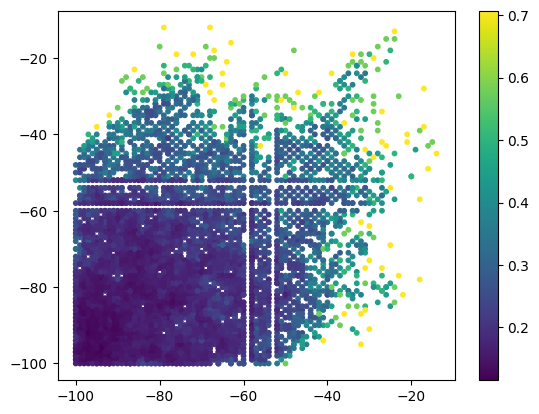

In [262]:
x = np.array([node.latent for node in ge.archive])
c = np.array([ge.archive.cell2n_seen[node.latent] for node in ge.archive])
c = 1./np.sqrt(c+1)
plt.scatter(*x.T, c=c, s=10.)
plt.colorbar()

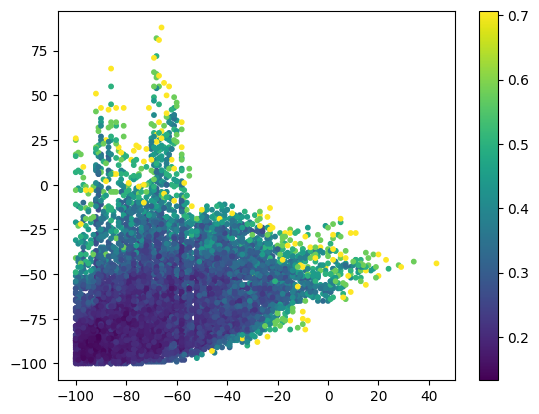

In [279]:
x = np.array([node.latent for node in ge.archive])
c = np.array([ge.archive.cell2n_seen[node.latent] for node in ge.archive])
c = 1./np.sqrt(c+1)
plt.scatter(*x.T, c=c, s=10.)
plt.colorbar()

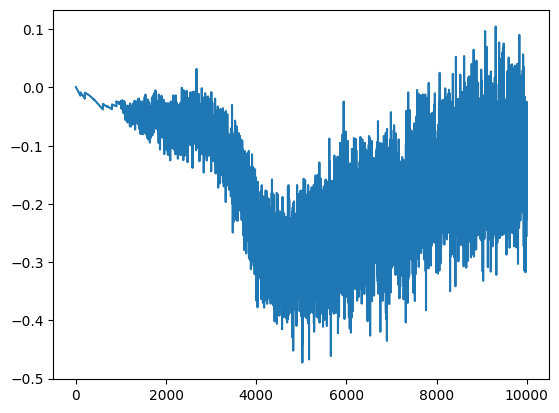

In [282]:
plt.plot(explorer.losses_all)

In [291]:
actions, log_probs, _, _, = explorer.get_action_and_value(torch.stack([node.obs for node in ge.archive]).to(device))

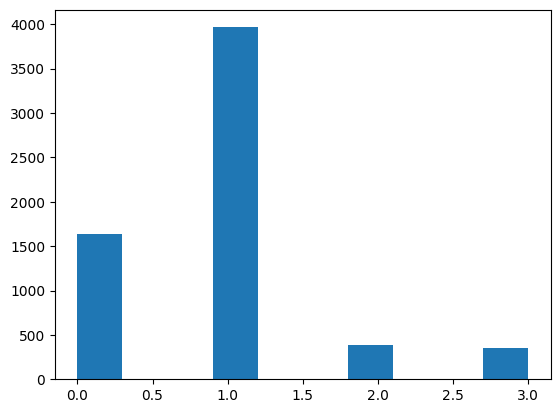

In [295]:
plt.hist(actions.detach().cpu().numpy());

  0%|          | 0/10 [00:00<?, ?it/s]

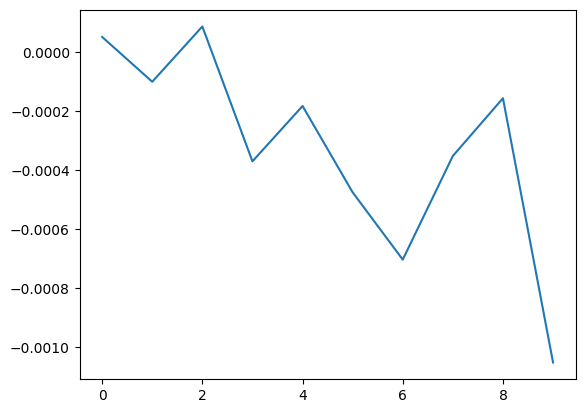

Action 0
-1.383995532989502
Action 1
-1.3778831958770752
Action 2
-1.3862355947494507
Action 3
-1.3971469402313232


In [226]:
def tensor_stack(a):
    if isinstance(a, torch.Tensor):
        return a
    elif isinstance(a, list):
        return torch.stack([tensor_stack(i) for i in a])
    
def update_policy(ge, n_steps, batch_size, viz=False):
    obs_good = tensor_stack([[trans[1] for trans in traj] for traj in ge.trajs_good])
    actions_good = tensor_stack([[trans[3] for trans in traj] for traj in ge.trajs_good])
    obs_good = obs_good.reshape(-1, obs_good.shape[-1])
    actions_good = actions_good.reshape(-1)
    
    obs_bad = tensor_stack([[trans[1] for trans in traj] for traj in ge.trajs_bad])
    actions_bad = tensor_stack([[trans[3] for trans in traj] for traj in ge.trajs_bad])
    obs_bad = obs_bad.reshape(-1, obs_bad.shape[-1])
    actions_bad = actions_bad.reshape(-1)
    # print(obs_bad.shape)
    # print(obs_good.shape)
    
    
    explorer = Explorer().to(device)
    opt = torch.optim.Adam(explorer.parameters(), lr=1e-4)
    
    losses = []
    for i_batch in tqdm(range(n_steps)):
        idx_good = torch.randperm(len(obs_good))[:batch_size//2]
        idx_bad = torch.randperm(len(obs_bad))[:batch_size//2]
        batch_obs_good = obs_good[idx_good].to(device)
        batch_obs_bad = obs_bad[idx_bad].to(device)
        batch_actions_good = actions_good[idx_good].to(device)
        batch_actions_bad = actions_bad[idx_bad].to(device)
        
        _, log_probs_good, entropy, _ = explorer.get_action_and_value(batch_obs_good, batch_actions_good)
        _, log_probs_bad, entropy, _ = explorer.get_action_and_value(batch_obs_bad, batch_actions_bad)
        
        loss = log_probs_bad.mean()-log_probs_good.mean()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
        
    
    batch_actions = torch.cat([batch_actions_good, batch_actions_bad], dim=0)
    log_probs = torch.cat([log_probs_good, log_probs_bad], dim=0)
    
    if viz:
        plt.plot(losses)
        plt.show()
        for i in range(4):
            print(f'Action {i}')
            print(log_probs[batch_actions==i].mean().item())

do_training(10, 2048)